In [2]:
from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
import numpy as np
from tqdm import tqdm
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc import waveform
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
%load_ext autoreload
%autoreload 2

# $EccTD$ $Eccentricity$

In [3]:
get_available_waveform_origins()

['LAL', 'SXSCatalog', 'LVCNR', 'LVCNR_hack', 'EOB', 'EMRI']

In [4]:
get_load_waveform_docs("LAL")

Help on function load_LAL_waveform in module gw_eccentricity.load_data:

load_LAL_waveform(**kwargs)
    Load waveforms calling the LAL Library.
    
    The kwargs could be the following:
    Run `load_data.get_load_waveform_defaults('LAL')` to see allowed
    keys and defaults.
    
    approximant: str
        Name of the waveform model to be used for generating the waveform.
    q: float
        Mass ratio of the system.
    chi1: 1d array of size 3
        3-element 1d array of spin components of the 1st Black hole.
    chi2: 1d array of size 3
        3-element 1d array of spin components of the 2nd Black hole.
    ecc: float
        Initial eccentricity of the binary at Momega0 (see below).
    mean_ano: float
        Initial Mean anomaly of the binary at Momega0 (see below).
    Momega0: float
        Starting orbital frequency in dimensionless units.
    deltaTOverM: float
        Time steps in dimensionless units.
    physicalUnits: bool
        If True, returns modes in MKS 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


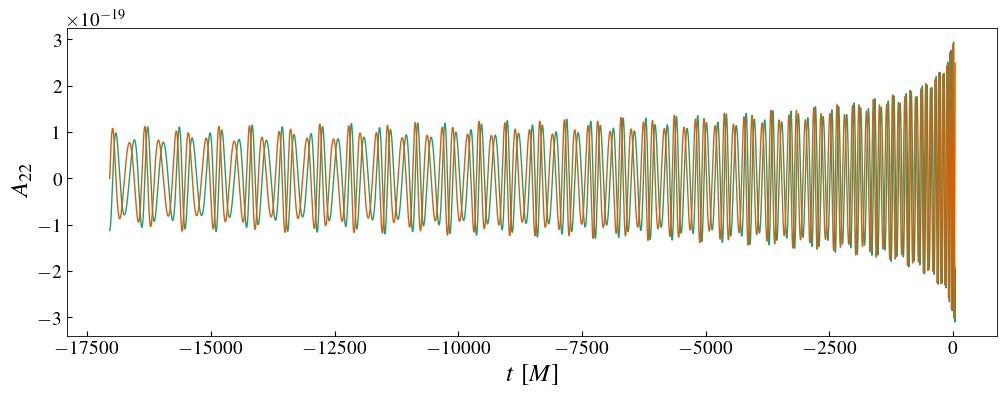

In [5]:
q=2.0
M=30
D=1
e0=0.120
D_SI=D*(10**(6))*PC_SI
M_SI=M*MSUN_SI
M1=q*M/(1+q)
M2=M/(1+q)
mode2polfac=4*(5/(64*np.pi))**(1/2)
kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": -0.181,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": M,
    "D":D,
    "include_zero_ecc":True,
}
origin = "LAL"
dataDict = load_waveform(origin, **kwargs)
use_fancy_plotsettings()
plt.figure(figsize=(12,4))
#plt.plot(dataDict["t"]/(M*MTSUN_SI), np.abs(dataDict["hlm"][(2,2)])/(G_SI*M_SI/D_SI/C_SI/C_SI),label=kwargs["approximant"])
# mode2polfac already taken care of in dataDict

hp = np.real(dataDict["hlm"][(2,2)])
hc = np.imag(dataDict["hlm"][(2,2)])
plt.plot(dataDict["t"]/(M*MTSUN_SI),hp,dataDict["t"]/(M*MTSUN_SI),hc)
plt.xlabel(labelsDict["t_dimless"])
plt.ylabel(labelsDict["amp22"])
plt.legend()
#print(len(np.abs(dataDict["hlm"][(2,2)])/(G_SI*M_SI/D_SI/C_SI/C_SI)))

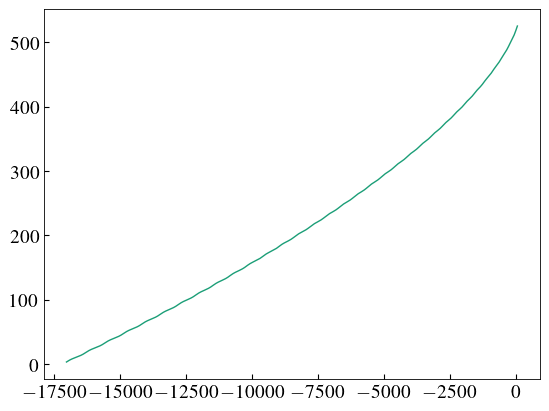

In [6]:
phaseEcc = np.unwrap(np.angle(hp-1j*hc)*2)/2
plt.plot(dataDict["t"]/(M*MTSUN_SI),phaseEcc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


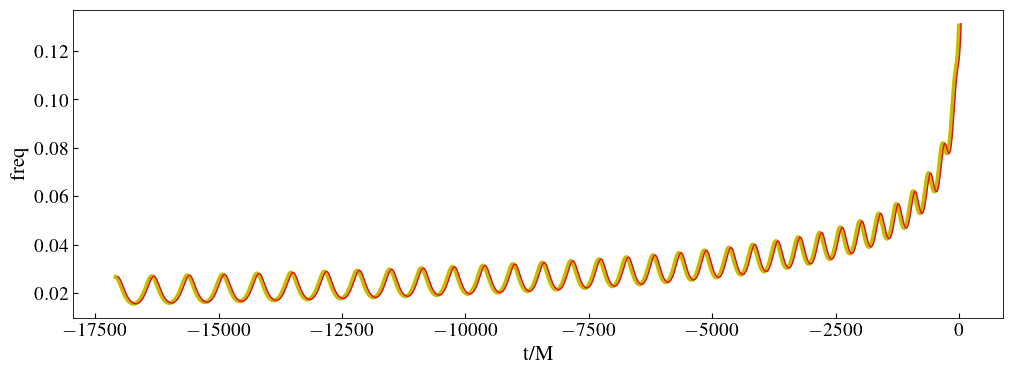

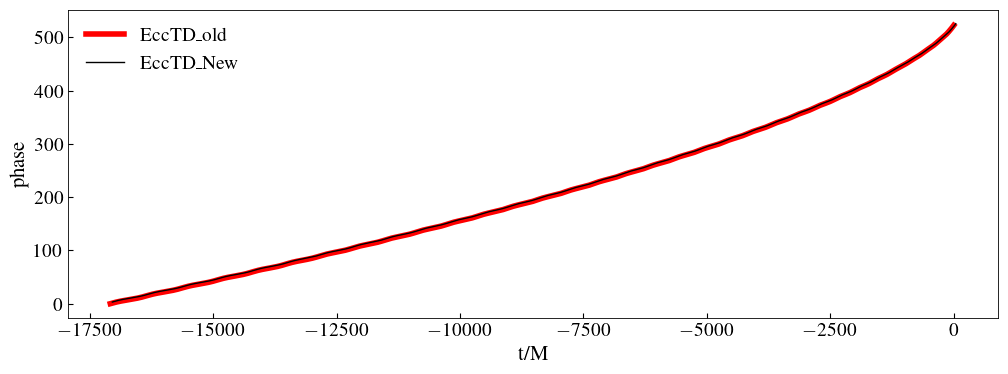

In [13]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=1./4096,f_lower=21.541668606103567,eccentricity=0.120)

phase_EccTD = waveform.utils.phase_from_polarizations(hp/(mode2polfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hc/(mode2polfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
plt.figure(figsize=(12,4))
delta_t =  np.abs(np.mean((np.diff(hp.sample_times/(M*MTSUN_SI)))))
plt.plot(hp.sample_times/(M*MTSUN_SI),np.gradient(phase_EccTD)/delta_t,'y',linewidth=3)

delta_t1 =  np.abs(np.mean((np.diff(dataDict["t"]/(M*MTSUN_SI)))))
plt.plot(dataDict["t"]/(M*MTSUN_SI),np.gradient(phaseEcc)/delta_t1,'r')
plt.ylabel('freq',fontsize=15)
plt.xlabel('t/M',fontsize=15)
plt.legend()

plt.figure(figsize=(12,4))
plt.ylabel('phase',fontsize=15)
plt.xlabel('t/M',fontsize=15)
plt.plot(hp.sample_times/(M*MTSUN_SI),phase_EccTD,'r',linewidth=4,label='EccTD_old')
plt.plot(dataDict["t"]/(M*MTSUN_SI),phaseEcc,'k',label='EccTD_New')
plt.legend()

In [6]:
get_available_methods()

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'AmplitudeFits',
 'FrequencyFits']

In [7]:
#MSUN_SI
#20*(30*MTSUN_SI)

In [8]:
# Measuring ecc at a ref freq
#tref_in = -4000*(M*MTSUN_SI)
fref_in=30
for method in get_available_methods():
    return_dict = measure_eccentricity(fref_in=fref_in,method=method,dataDict=dataDict)
    
    tref_out = return_dict["fref_out"]
    eccentricity = return_dict["eccentricity"]
    mean_anomaly = return_dict["mean_anomaly"]
    gwecc_object = return_dict["gwecc_object"]
    print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean_anomaly={mean_anomaly:.6f}")

method = Amplitude            eccentricity = 0.135475, mean_anomaly=3.425128
method = Frequency            eccentricity = 0.135465, mean_anomaly=3.437708
method = ResidualAmplitude    eccentricity = 0.135500, mean_anomaly=3.459188
method = ResidualFrequency    eccentricity = 0.135500, mean_anomaly=3.460309
method = AmplitudeFits        eccentricity = 0.135499, mean_anomaly=3.457417
method = FrequencyFits        eccentricity = 0.135500, mean_anomaly=3.460336


In [9]:
#help(gwecc_object)

[-16309.64315302 -16309.54315302 -16309.44315302 ...   -446.34315302
   -446.24315302   -446.14315302]


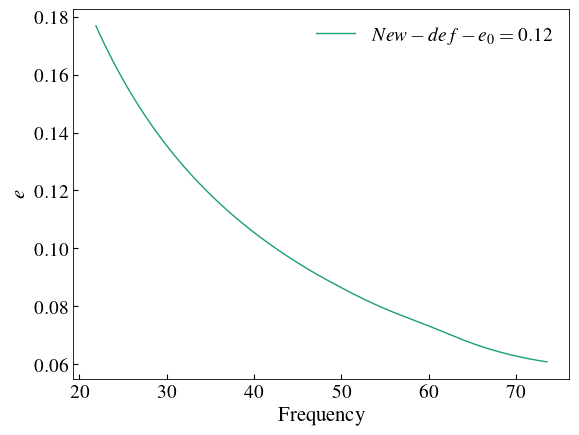

In [15]:
#Diagnostic Plots
method = "ResidualAmplitude"
return_dict = measure_eccentricity(fref_in=fref_in,method=method,dataDict=dataDict)
return_dict
gwecc_object = return_dict["gwecc_object"]
#plt.figure(figsize=(6,6))
#fig, ax=gwecc_object.plot_eccentricity()
Time_data=gwecc_object.get_omega22_average()[0]  #doing this to extract the time values
Omega_avg=gwecc_object.get_omega22_average()[1]
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict)
ECC_data_new=(return_dict1["eccentricity"])
#plt.plot(Time_data/(M*MTSUN_SI),ECC_data_new,label=r"$New-def-e_0=0.12$")
plt.plot(Omega_avg/(2*PI),ECC_data_new,label=r"$New-def-e_0=0.12$")
plt.legend()
#plt.xlabel(r"$t/M$",size=15)
plt.xlabel(r'Frequency',size=15)
plt.ylabel(r'$e$',size=15)
print(Time_data/(M*MTSUN_SI))
#plt.savefig('New_e-t.png',dpi=300)
#plt.savefig('New_e-f.png',dpi=300)

# $NR$ $Eccentricity$

In [16]:
#origin = "SXSCatalog"
#get_load_waveform_defaults(origin)

#export LAL_DATA_PATH='home/pratul/Downloads/'  #first run this in command line then run jupyter notebook

In [17]:
#kwargs = {"filepath": '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5',
         #"metadata_path": '/home/pratul/Downloads/metadata.txt',
         #"include_zero_ecc":True,
         #"zero_ecc_approximant": "SEOBNRv4HM"}

#dataDict1 = load_waveform(origin, **kwargs)
##plt.figure(figsize=(12,4))
#plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2,2)]),label=origin+' '+str(1364))
#plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2,2)]),label=kwargs["zero_ecc_approximant"] + " e = 0")
#plt.xlim(dataDict["t"][0],200)
#plt.xlabel(labelsDict["t_dimless"])
#plt.ylabel(labelsDict["amp22"])
#plt.legend(loc="upper left")

In [18]:
# Measuring ecc at a ref freq
#tref_in = -1000
#for method in get_available_methods():
    #return_dict = measure_eccentricity(tref_in=tref_in,method=method,dataDict=dataDict1)
    
    #tref_out = return_dict["tref_out"]
    #eccentricity = return_dict["eccentricity"]
    #mean_anomaly = return_dict["mean_anomaly"]
    #gwecc_object = return_dict["gwecc_object"]
    #print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean_anomaly={mean_anomaly:.6f}")

In [19]:
#Diagnostic Plots
#method = "ResidualAmplitude"
#tref_in=-1000
#return_dict = measure_eccentricity(tref_in=tref_in,method=method,dataDict=dataDict1)

#gwecc_object = return_dict["gwecc_object"]
#fig, ax=gwecc_object.make_diagnostic_plots()
#plt.savefig('NR.pdf')

# Old ecc definition (LALINSPIRALECCTD)


In [20]:
import lalsimulation as lalsim
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from ctypes import *
import numpy as np
import matplotlib.pyplot as plt
import math
import lal

In [21]:
#conversion from freq param x to freq in Hz for (2,2) mode
def f(u,mass):
    return math.pow(u,3.0/2.0)/(MTSUN_SI * mass * lal.PI)

In [22]:
#conversion from freq in Hz to freq param
def xconv(f,mass):
    return (MTSUN_SI * mass * lal.PI * f)**(2/3)

In [23]:
q=q
Mtot=M
M1=q*Mtot/(1+q) * MSUN_SI
M2=Mtot/(1+q) * MSUN_SI
M=(M1+M2)/MSUN_SI
#eref = 2e-6
e_min=0.120
n=0
phi_ref=0
xmin=0.046415888336127795 #obtained using Momega0=0.01
xref=0.075

In [24]:
print(f(0.046415888336127795,30)) 
0.01**(2/3)   #gw_eccentricity uses Momega0. so freq param x=(Momega0)**(2/3). 

21.541668606103567


0.046415888336127795

In [25]:
v, et, l, lmda, u, phi = lalsim.SimInspiralEccentricTDPNEvolveOrbit(phiRef=phi_ref,deltaT=1/2048,m1=M1, m2=M2, f_min=f(xmin,M), fRef=f(xref,M), e_min=e_min,O=-1)

In [26]:
for i in range(0,phi.data.length):
    if phi.data.data[i]==phi_ref:
        idx=i
        
print(phi.data.data[idx])
print(et.data.data[idx])
print(f(xmin,M))
print(f(xref,M))

0.0
0.052222187391193
21.541668606103567
44.245716831989206


In [27]:
time1=np.empty(phi.data.length)
time1[0] = phi.epoch
for i in range(1,phi.data.length):
    time1[i]=time1[i-1]+et.deltaT

print(time1[0]/(Mtot*MTSUN_SI))    

-17084.00948527026


5170


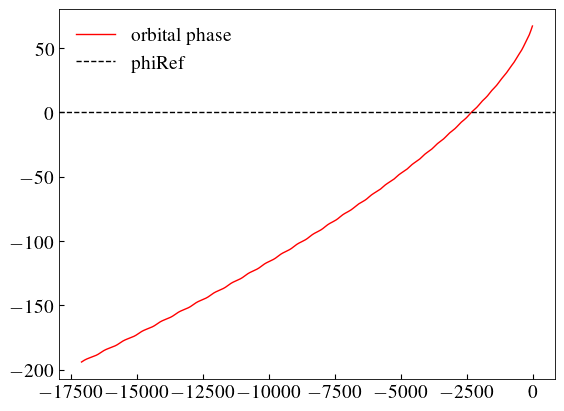

In [28]:
plt.plot(time1/(Mtot*MTSUN_SI),phi.data.data,'r',label='orbital phase')
plt.axhline(y=0,color='k',ls='--',label='phiRef')
plt.legend()
print(phi.data.length)

In [29]:
print(phi.deltaT)

0.00048828125


In [30]:
omega=(np.gradient(phi.data.data))/phi.deltaT
freq=omega/(2*PI)
print(phi.data.data)

[-193.9492212  -193.90328411 -193.85736372 ...   66.80153819   67.01300134
   67.22749995]


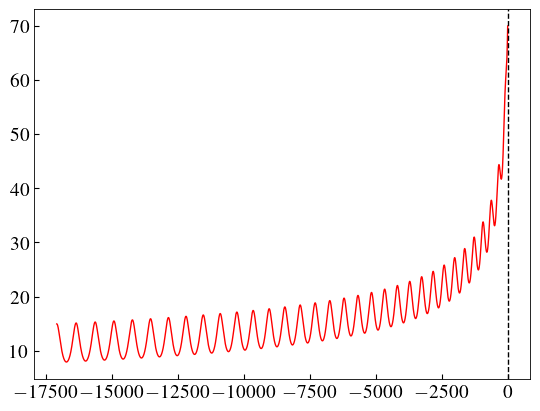

In [31]:
plt.plot(time1/(Mtot*MTSUN_SI),freq,'r',label='orbital frequency')
plt.axvline(x=time1[idx],color='k',ls='--',label='ref_time')

[-1.70840095e+04 -1.70807050e+04 -1.70774006e+04 ... -9.91334835e+00
 -6.60889777e+00 -3.30444719e+00]


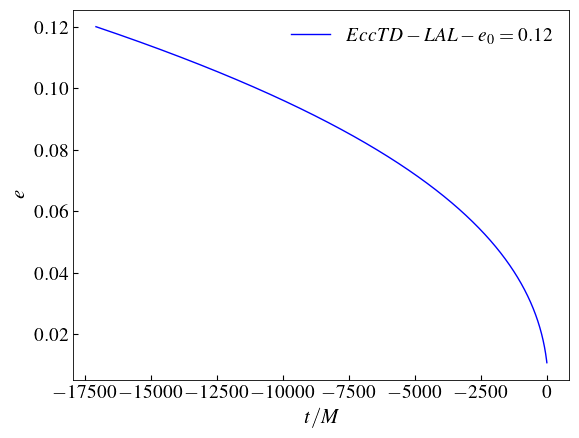

In [32]:
plt.plot(time1/(Mtot*MTSUN_SI),et.data.data,'b',label=r'$EccTD-LAL-e_0=0.12$')
#plt.axhline(y=et.data.data[idx],color='k',ls='--',label='e_ref')
#plt.axvline(x=-4000,color='k',ls='--',label='t_ref')
print(time1/(Mtot*MTSUN_SI))
plt.xlabel(r'$t/M$',size=15)
plt.ylabel(r'$e$',size=15)
plt.legend()
plt.savefig('LAL_e-t.png',dpi=300)


In [33]:
#help(find_peaks)

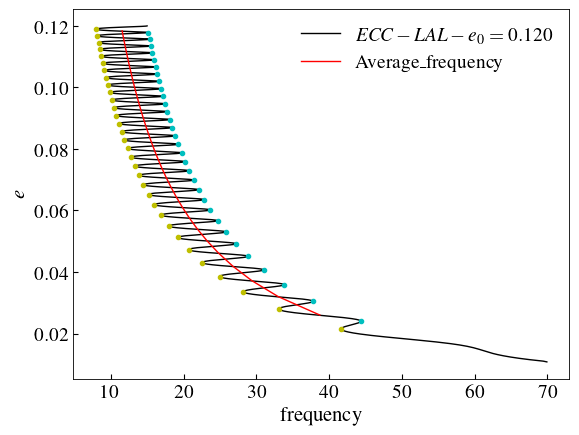

In [34]:
indices_crest=find_peaks(freq,prominence=1)[0]
indices_trough=find_peaks(-freq,prominence=1)[0]
freq_crest=freq[indices_crest]
freq_trough=freq[indices_trough]
e_crest=(et.data.data)[indices_crest]
e_trough=(et.data.data)[indices_trough]
ff=np.delete(freq[indices_trough],-1)
ee=np.delete((et.data.data)[indices_trough],-1)
avg_freq=0.5*(np.array(freq_crest)+np.array(ff))
avg_et=0.5*(np.array(e_crest)+np.array(ee))
plt.plot(freq,et.data.data,'k-',label=r'$ECC-LAL-e_0=0.120$')
plt.plot(freq_crest,e_crest,'co',markersize=3)
plt.plot(freq_trough,e_trough,'yo',markersize=3)
plt.plot(avg_freq,avg_et,'r-',linewidth=1,label='Average_frequency')
plt.xlabel('frequency',size=15)
plt.ylabel(r'$e$',size=15)
plt.legend()
plt.savefig('LAL_e-f.png',dpi=300)

# Old Ecc defintion (Moore et. al.)

In [35]:
%run GW_functions.ipynb

In [36]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    fVec_PN=waveform.utils.frequency_from_polarizations(hpVec_PN, hcVec_PN)
    return phase_EccTD, tVec_PN

10311
[-17082.35726421 -17080.70503892 -17079.05281363 ...   -234.61599189
   -232.9637666    -231.31154131]


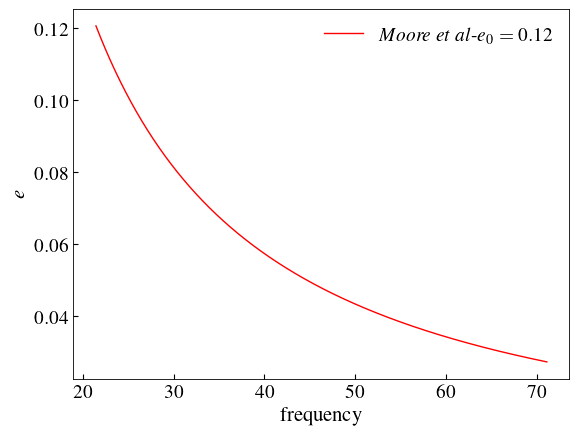

In [37]:
eta=q/(1+q)**2
EulerGamma=0.577215664901
phase_EccTD, tVec_PN= PNparams(M,q,D,21.541668606103567,e0,1.0/4096)
tC_NR=0
M_new=1
x0=xlow=0.046415888336127795
xi0=x0**(3/2)
v0=xi0**(1/3)
theta=((5*M_new/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M_new/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta,theta0,e0,M_new,eta)
plotIdx2=np.nonzero(fVec>0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M_new*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec=xVec[xband]
maxPNidx=len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
print(len(fVec))
Ecc_Moore=[]
for i in xVec:
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    Ecc_Moore.append(e)

time=tVec_PN
print(time[:10200])
#np.delete(Ecc_Moore,-1)
#plt.plot(time[:10200],Ecc_Moore[:10200],'r-',label=r'$Moore$ $et$ $al$-$e_0=0.12$')
plt.plot(fVec[:10200]/(M*MTSUN_SI),Ecc_Moore[:10200],'r-',label=r'$Moore$ $et$ $al$-$e_0=0.12$')
#plt.xlabel(r't/M',size=15)
plt.xlabel(r'frequency',size=15)
plt.ylabel(r'$e$',size=15)
plt.legend()
#plt.savefig('Moore_e-t.png',dpi=300)
plt.savefig('Moore_e-f.png',dpi=300)
#plt.ylim(0,0.13)

In [38]:
a=np.array([-1,2,3])
np.delete(a,2)

array([-1,  2])

In [39]:
intrp_Moore = interp1d(fVec[:10200]/(M*MTSUN_SI),Ecc_Moore[:10200],kind='cubic',fill_value='extrapolate')
intrp_LAL = interp1d(avg_freq,avg_et,kind='cubic',fill_value='extrapolate')

100%|███████████████████████████████████████████| 38/38 [02:03<00:00,  3.25s/it]


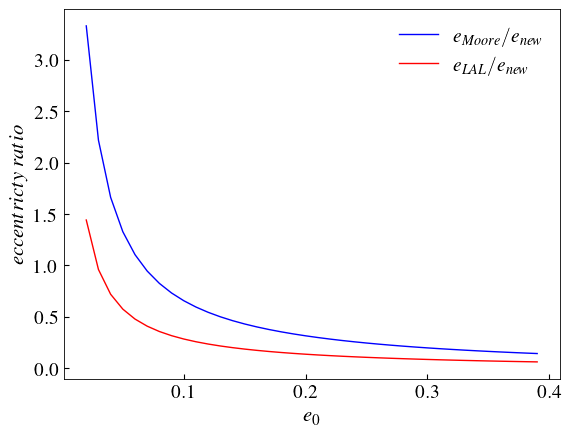

In [40]:
ecc0=np.arange(0.02,0.40,0.01)
ecc_comp_Moore_new=[]
ecc_comp_LAL_new=[]
ecc_comp1_Moore_new=[]
ecc_comp1_LAL_new=[]
fref_in=40
for i in tqdm(ecc0):
    kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": i,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": 0.0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": Mtot,
    "D":D,
    "include_zero_ecc":True,
    }
    origin = "LAL"
    dataDict_new = load_waveform(origin, **kwargs)
    method = "ResidualAmplitude"
    return_dict_new = measure_eccentricity(fref_in=fref_in,method=method,dataDict=dataDict_new)
    ecc_new=return_dict_new['eccentricity']
    ecc_LAL=intrp_LAL(fref_in)
    ecc_Moore=intrp_Moore(fref_in)
    #print(ecc_new,ecc_LAL,ecc_Moore)
    #print('\n')
    ecc_comp_Moore_new.append(ecc_Moore/ecc_new)
    ecc_comp_LAL_new.append(ecc_LAL/ecc_new)
    ecc_comp1_Moore_new.append(abs(ecc_new-ecc_Moore))
    ecc_comp1_LAL_new.append(abs(ecc_new-ecc_LAL))
    
plt.plot(ecc0,ecc_comp_Moore_new,'b',label=r'$e_{Moore}/e_{new}$')
plt.plot(ecc0,ecc_comp_LAL_new,'r',label=r'$e_{LAL}/e_{new}$')
plt.xlabel(r'$e_0$',size=15)
plt.ylabel(r'$eccentricty$ $ratio$',size=15)
plt.legend()
#plt.savefig('ecc_ratio.png',dpi=300) 

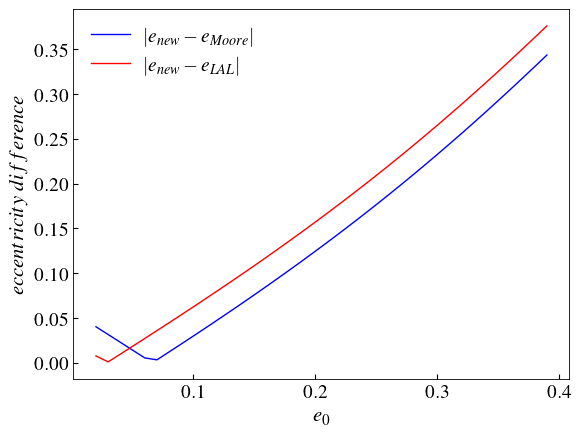

In [42]:
plt.plot(ecc0,ecc_comp1_Moore_new,'b',label=r'$|e_{new}-e_{Moore}|$')
plt.plot(ecc0,ecc_comp1_LAL_new,'r',label=r'$|e_{new}-e_{LAL}|$')
plt.xlabel(r'$e_0$',size=15)
plt.ylabel(r'$eccentricity$ $difference$',size=15)
plt.legend()
plt.savefig('ecc_abs_difference.png',dpi=300)

# $Evolving$ $Ebersold$ $using$ $gw__eccentricity$ $package$

In [52]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [70]:
e0=0.12
inc=0
l0=-0.181
q=2
M=d=d0=1
kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": 0.0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": Mtot,
    "D":D,
    "include_zero_ecc":True,
    }

eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))
method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)
gwecc_object = return_dict["gwecc_object"]
Time_data=gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg=gwecc_object.get_omega22_average()[1]
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict)
Fvec=Omega_avg/(2*PI) #Average frequency array
Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]
xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
#xband=np.where(xVec<=1/6)
#xVec = xVec[:12000]

phase_EccTD, tVec_PN = PNparams(M,q,d,21.541668606103567,e0,1.0/4096)

print(len(xVec))
j=0
lp=2
mp=2
h22=[]
h2_2=[]
hlm_real=[]
hlm_imag=[]
hlm_abs22=[]
for i in tqdm(xVec):
    count=0
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[count]
    e=Eccentricity_new[count]
    psi=phase_EccTD[j]
    j=j+1
    count+=1
    xi=l
    x=i
    
    h=amplitude_22(xi,x,nu,Delta,e)
    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
    
    h22.append(hlm)
    h2_2.append(hl_m)

conv_t=Mtot*MTSUN_SI
conv_h=G_SI*Mtot*MSUN_SI/(10**6 * PC_SI *d0)/C_SI/C_SI

sph22,sph2_2 = sph_harmonics(inc,lp)

h=np.multiply(h22,sph22)
hp=(np.real(h))
hc=(np.imag(h))
time=Time_data-Time_data[-1]

mode2polfac=(5/(64*np.pi))**(1/2)
hp=np.array(hp) * conv_h
hc=np.array(hc) * conv_h
time=Time_data * conv_t

hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp = np.arange(time[0], time[-1], 1.0/4096)
hp_intrp = hp_intrp(t_intrp)
hc_intrp = hc_intrp(t_intrp)
    
h22Ecc=hp_intrp + 1j*hc_intrp

158636


100%|█████████████████████████████████| 158636/158636 [02:27<00:00, 1072.53it/s]
